# Canadian Housing Market Analysis
## CPSC 4310 - Data Analytics Project

**Team:** Project Group A  
**Student:** Chloe Lee (EDA & Modeling)  
**Date:** February 2025

---

## Project Overview

This notebook performs exploratory data analysis and predictive modeling on Canadian housing prices across 5 major cities:
- Greater Vancouver
- Greater Toronto
- Calgary
- Ottawa
- Montreal

**Goal:** Predict housing price changes using interest rates and mortgage indicators.

**Data Sources:**
- MLS Home Price Index (2005-2025)
- Bank of Canada Interest Rates (2005-2025)

---
# Part 1: Setup and Data Loading

In [179]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully!")
print(f"  Pandas version: {pd.__version__}")
print(f"  NumPy version: {np.__version__}")

✓ Libraries imported successfully!
  Pandas version: 2.2.3
  NumPy version: 2.0.2


In [180]:
# Load datasets
print("Loading datasets...")

# Update these paths to where you saved the CSV files
housing = pd.read_csv('../01_Data/Monthly Home Price and Index by type and city(in).csv')
rates = pd.read_csv('../01_Data/Daily Rates(in).csv')

print(f"✓ Housing data loaded: {housing.shape[0]} rows, {housing.shape[1]} columns")
print(f"✓ Rates data loaded: {rates.shape[0]} rows, {rates.shape[1]} columns")

Loading datasets...
✓ Housing data loaded: 7670 rows, 5 columns
✓ Rates data loaded: 7670 rows, 6 columns


Note: This dataset is already aggregated/merged and does not include City or House_Type columns.

In [181]:
print("=" * 80)
print("INTEREST RATE DATA PREVIEW")
print("=" * 80)
display(rates.head())
print(f"\nColumns: {rates.columns.tolist()}")
print(f"Date Range: {rates['Date'].min()} to {rates['Date'].max()}")

INTEREST RATE DATA PREVIEW


,Date,Mortgage_1Y,Mortgage_3Y,Mortgage_5Y,Prime_Rate,Policy_Rate
0,1/1/2005,4.25,4.8,5.6,6.05,NaN
1,1/2/2005,4.25,4.8,5.6,6.05,NaN
2,1/3/2005,4.25,4.8,5.6,6.05,NaN
3,1/4/2005,4.25,4.8,5.6,6.05,NaN
4,1/5/2005,4.25,4.8,5.6,6.05,NaN



Columns: ['Date', 'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate', 'Policy_Rate']
Date Range: 1/1/2005 to 9/9/2025


---
# Part 2: Data Preprocessing and Integration

In [182]:
# Step 1: Convert dates to datetime format
print("[1/6] Converting date formats...")
housing['Date'] = pd.to_datetime(housing['Date'])
rates['Date'] = pd.to_datetime(rates['Date'])

print(f"✓ Housing date range: {housing['Date'].min()} to {housing['Date'].max()}")
print(f"✓ Rates date range: {rates['Date'].min()} to {rates['Date'].max()}")

[1/6] Converting date formats...
✓ Housing date range: 2005-01-01 00:00:00 to 2025-12-31 00:00:00
✓ Rates date range: 2005-01-01 00:00:00 to 2025-12-31 00:00:00


In [183]:
# Step 2: Composite house type filtering  
# This dataset has already been filtered to Composite house type during preprocessing.
# City and House_Type columns are no longer included in this stage.
housing_composite = housing.copy()

if 'House_Type' in housing.columns:
    housing_composite = housing[housing['House_Type'] == 'Composite'].copy()

if 'City' in housing_composite.columns:
    print(f"Cities: {housing_composite['City'].unique().tolist()}")

In [184]:
# Step 3: Convert daily rates to monthly (aggregate by month)
print("[3/6] Converting daily rates to monthly averages...")

rates['YearMonth'] = rates['Date'].dt.to_period('M')
rates_monthly = rates.groupby('YearMonth').agg({
    'Mortgage_1Y': 'mean',
    'Mortgage_3Y': 'mean',
    'Mortgage_5Y': 'mean',
    'Prime_Rate': 'mean',
    'Policy_Rate': 'mean'
}).reset_index()

rates_monthly['Date'] = rates_monthly['YearMonth'].dt.to_timestamp()
rates_monthly = rates_monthly.drop('YearMonth', axis=1)

print(f"✓ Converted to monthly: {len(rates_monthly)} rows")

[3/6] Converting daily rates to monthly averages...
✓ Converted to monthly: 252 rows


In [185]:
# Step 4: Merge housing and rates data
print("[4/6] Merging housing and rates data...")

df = housing_composite.merge(rates_monthly, on='Date', how='left')

print(f"✓ Merged dataset: {len(df)} rows, {len(df.columns)} columns")
print(f"  Columns: {df.columns.tolist()}")

[4/6] Merging housing and rates data...
✓ Merged dataset: 7670 rows, 10 columns
  Columns: ['Date', 'Mortgage_1Y_x', 'Mortgage_3Y_x', 'Mortgage_5Y_x', 'Prime_Rate_x', 'Mortgage_1Y_y', 'Mortgage_3Y_y', 'Mortgage_5Y_y', 'Prime_Rate_y', 'Policy_Rate']


In [186]:
# Step 5: Check for missing values
print("[5/6] Checking for missing values...")

missing = df.isnull().sum()
missing = missing[missing > 0]

if len(missing) > 0:
    print("\nMissing values found:")
    for col, count in missing.items():
        pct = (count / len(df)) * 100
        print(f"  {col:20} : {count:4} ({pct:5.1f}%)")
else:
    print("✓ No missing values!")

[5/6] Checking for missing values...

Missing values found:
  Mortgage_1Y_y        : 7418 ( 96.7%)
  Mortgage_3Y_y        : 7418 ( 96.7%)
  Mortgage_5Y_y        : 7418 ( 96.7%)
  Prime_Rate_y         : 7418 ( 96.7%)
  Policy_Rate          : 7551 ( 98.4%)


In [187]:
# Step 6: Sort by City and Date
print("[6/6] Sorting data by Date...")

df = df.sort_values('Date').reset_index(drop=True)

print("✓ Data sorted by Date")
print("=" * 80)
print("DATA PREPROCESSING COMPLETE!")
print("=" * 80)
print(f"Final dataset: {len(df)} rows × {len(df.columns)} columns")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

[6/6] Sorting data by Date...
✓ Data sorted by Date
DATA PREPROCESSING COMPLETE!
Final dataset: 7670 rows × 10 columns
Date range: 2005-01-01 00:00:00 to 2025-12-31 00:00:00


In [188]:
# Preview merged data
print("\nMerged Data Preview:")
display(df.head(10))


Merged Data Preview:


,Date,Mortgage_1Y_x,Mortgage_3Y_x,Mortgage_5Y_x,Prime_Rate_x,Mortgage_1Y_y,Mortgage_3Y_y,Mortgage_5Y_y,Prime_Rate_y,Policy_Rate
0,2005-01-01,4.25,4.8,5.6,6.05,4.25,4.8,5.6,6.05,NaN
1,2005-01-02,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
3,2005-01-04,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
4,2005-01-05,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
5,2005-01-06,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
6,2005-01-07,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
7,2005-01-08,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
8,2005-01-09,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN
9,2005-01-10,4.25,4.8,5.6,6.05,NaN,NaN,NaN,NaN,NaN


---
# Part 3: Feature Engineering

We create three types of features:
1. **Lag Features** - Past values (1, 3, 12 months ago)
2. **Change Features** - Month-over-month and year-over-year changes
3. **Rolling Averages** - Smoothed trends (3-month, 12-month)

In [189]:
print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

print(f"\nStarting with: {len(df)} rows, {len(df.columns)} columns")

FEATURE ENGINEERING

Starting with: 7670 rows, 10 columns


In [193]:
# Part 3: Feature Engineering
print(df.columns)
print(df.index.names)
print(list(df.columns))
print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

if 'City' not in df.columns:
    df = df.reset_index()

print(f"\nStarting with: {len(df)} rows, {len(df.columns)} columns")

# 1. Lag Features (past values)
print("\n[1/5] Creating Lag Features...")

df = df.sort_values(['City', 'Date'])

df['Index_Lag1']  = df.groupby('City')['Index'].shift(1)
df['Index_Lag3']  = df.groupby('City')['Index'].shift(3)
df['Index_Lag12'] = df.groupby('City')['Index'].shift(12)

print("✓ Created: Index_Lag1, Index_Lag3, Index_Lag12")

Index(['level_0', 'index', 'Date', 'Mortgage_1Y_x', 'Mortgage_3Y_x',
       'Mortgage_5Y_x', 'Prime_Rate_x', 'Mortgage_1Y_y', 'Mortgage_3Y_y',
       'Mortgage_5Y_y', 'Prime_Rate_y', 'Policy_Rate'],
      dtype='object')
[None]
['level_0', 'index', 'Date', 'Mortgage_1Y_x', 'Mortgage_3Y_x', 'Mortgage_5Y_x', 'Prime_Rate_x', 'Mortgage_1Y_y', 'Mortgage_3Y_y', 'Mortgage_5Y_y', 'Prime_Rate_y', 'Policy_Rate']
FEATURE ENGINEERING


ValueError: cannot insert level_0, already exists

In [ ]:
# 2. Change Features (% changes)
print("\n[2/5] Creating Change Features...")

# Month-over-Month change (MoM)
df['Index_MoM_Change'] = df.groupby('City')['Index'].pct_change(1) * 100

# Year-over-Year change (YoY)
df['Index_YoY_Change'] = df.groupby('City')['Index'].pct_change(12) * 100

# Mortgage rate change
df['Mortgage_5Y_Change'] = df.groupby('City')['Mortgage_5Y'].diff()

print("✓ Created: Index_MoM_Change, Index_YoY_Change, Mortgage_5Y_Change")

In [ ]:
# 3. Rolling Averages (smoothed trends)
print("\n[3/5] Creating Rolling Averages...")

# 3-month moving average
df['Index_MA3'] = df.groupby('City')['Index'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)

# 12-month moving average
df['Index_MA12'] = df.groupby('City')['Index'].transform(
    lambda x: x.rolling(12, min_periods=1).mean()
)

print("✓ Created: Index_MA3, Index_MA12")

In [ ]:
# 4. Time Features
print("\n[4/5] Creating Time Features...")

df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Year'] = df['Date'].dt.year

print("✓ Created: Month, Quarter, Year")

In [ ]:
# 5. Derived Features
print("\n[5/5] Creating Derived Features...")

# Distance from moving average (momentum indicator)
df['Price_Above_MA3'] = df['Index'] - df['Index_MA3']

# Short-term vs long-term trend
df['MA3_MA12_Diff'] = df['Index_MA3'] - df['Index_MA12']

print("✓ Created: Price_Above_MA3, MA3_MA12_Diff")

In [ ]:
# Summary of feature engineering
print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPLETE!")
print("=" * 80)
print(f"Total columns now: {len(df.columns)}")

new_features = [
    'Index_Lag1', 'Index_Lag3', 'Index_Lag12',
    'Index_MoM_Change', 'Index_YoY_Change', 'Mortgage_5Y_Change',
    'Index_MA3', 'Index_MA12',
    'Month', 'Quarter', 'Year',
    'Price_Above_MA3', 'MA3_MA12_Diff'
]

print(f"\nNew features created ({len(new_features)}):")
for i, feat in enumerate(new_features, 1):
    print(f"  {i:2}. {feat}")

In [ ]:
# Check for missing values after feature engineering
print("\nMissing values after feature engineering:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

for col, count in missing.items():
    pct = (count / len(df)) * 100
    print(f"  {col:25} : {count:4} ({pct:5.1f}%)")

In [ ]:
# Example: Vancouver data with features
df = df.copy()
df['City'] = 'Greater Vancouver'

print("\nExample: Vancouver data (2006-01 to 2006-06)")

sample = df[
    (df['City'] == 'Greater Vancouver') &
    (df['Date'] >= '2006-01-01') &
    (df['Date'] <= '2006-06-01')
]

display(sample[
    [
        'Date',
        'Mortgage_1Y_x',
        'Mortgage_3Y_x',
        'Mortgage_5Y_x',
        'Prime_Rate_x',
        'Policy_Rate'
    ]
])

---
# Part 4: Exploratory Data Analysis (EDA)

Now let's visualize the data to understand patterns and relationships.

Creating visualization 1: Price Trends by City...


KeyError: 'City'

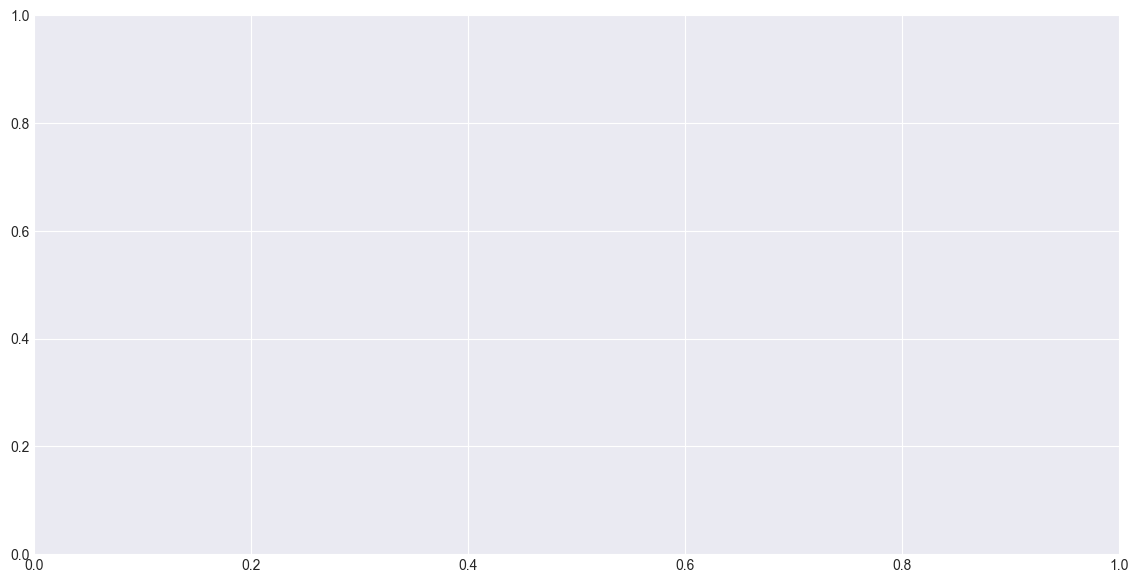

In [ ]:
# EDA 1: Housing Price Trends by City
print("Creating visualization 1: Price Trends by City...")

fig, ax = plt.subplots(figsize=(14, 7))

cities = df['City'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(cities)))

for city, color in zip(cities, colors):
    city_data = df[df['City'] == city].sort_values('Date')
    ax.plot(
        city_data['Date'],
        city_data['Index'],
        label=city,
        linewidth=2.5,
        color=color,
        alpha=0.8
    )

# Event markers
ax.axvline(pd.to_datetime('2008-09-01'), color='red', linestyle='--', alpha=0.3)
ax.axvline(pd.to_datetime('2020-03-01'), color='orange', linestyle='--', alpha=0.3)
ax.axvline(pd.to_datetime('2022-03-01'), color='purple', linestyle='--', alpha=0.3)

ax.set_title('Housing Price Index Trends by City', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price Index (2005=100)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization 1 complete")

In [ ]:
# Statistics by city
print("\nPrice Index Statistics by City:")
print("=" * 80)

stats = df.groupby('City')['Index'].agg(['min', 'max', 'mean', 'std'])
stats['growth'] = ((stats['max'] - stats['min']) / stats['min'] * 100)
stats = stats.round(2)

display(stats)

In [ ]:
# EDA 2: Interest Rate Trends
print("Creating visualization 2: Interest Rate Trends...")

# Get unique monthly rates
rates_df = df[['Date', 'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate']].drop_duplicates('Date').sort_values('Date')

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(rates_df['Date'], rates_df['Mortgage_5Y'], label='5-Year Mortgage', 
        linewidth=2.5, color='#e74c3c')
ax.plot(rates_df['Date'], rates_df['Mortgage_3Y'], label='3-Year Mortgage', 
        linewidth=2, color='#3498db', alpha=0.7)
ax.plot(rates_df['Date'], rates_df['Mortgage_1Y'], label='1-Year Mortgage', 
        linewidth=2, color='#2ecc71', alpha=0.7)
ax.plot(rates_df['Date'], rates_df['Prime_Rate'], label='Prime Rate', 
        linewidth=2, color='#f39c12', linestyle='--', alpha=0.7)

# Event markers
ax.axvline(pd.to_datetime('2020-03-01'), color='orange', linestyle='--', alpha=0.3)
ax.text(pd.to_datetime('2020-03-01'), ax.get_ylim()[1]*0.95, 
        'COVID\n(Rates Drop)', rotation=0, va='top', ha='left', fontsize=9)

ax.axvline(pd.to_datetime('2022-03-01'), color='red', linestyle='--', alpha=0.3)
ax.text(pd.to_datetime('2022-03-01'), ax.get_ylim()[1]*0.95, 
        'Rate\nHikes', rotation=0, va='top', ha='left', fontsize=9)

ax.set_title('Interest Rate Trends (2005-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Interest Rate (%)', fontsize=12)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Visualization 2 complete")

In [ ]:
# EDA 3: Dual-Axis Chart (Price vs Interest Rate)
print("Creating visualization 3: Vancouver Price vs Mortgage Rate...")

van_data = df[df['City'] == 'Greater Vancouver'].sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14, 7))

# Price Index (left axis)
color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Price Index (2005-01 = 100)', color=color, fontsize=12, fontweight='bold')
ax1.plot(van_data['Date'], van_data['Index'], color=color, linewidth=3, label='Price Index')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Mortgage Rate (right axis)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('5-Year Mortgage Rate (%)', color=color, fontsize=12, fontweight='bold')
ax2.plot(van_data['Date'], van_data['Mortgage_5Y'], color=color, linewidth=2.5, 
         linestyle='--', alpha=0.8, label='5Y Mortgage Rate')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Greater Vancouver: Housing Price vs Mortgage Rate\n(Inverse Relationship)', 
          fontsize=16, fontweight='bold', pad=20)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

fig.tight_layout()
plt.show()

print("✓ Visualization 3 complete")

In [ ]:
# EDA 4: Correlation Heatmap
print("Creating visualization 4: Correlation Heatmap...")

# Select numeric features
numeric_features = [
    'Index', 'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate',
    'Index_Lag1', 'Index_Lag3', 'Index_Lag12',
    'Index_MoM_Change', 'Index_YoY_Change',
    'Index_MA3', 'Index_MA12'
]

# Calculate correlation
corr_data = df[numeric_features].dropna()
correlation_matrix = corr_data.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True, 
            linewidths=1,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Visualization 4 complete")

In [ ]:
# Top correlations with Index
print("\nTop Correlations with Housing Price Index:")
print("=" * 60)

index_corr = correlation_matrix['Index'].sort_values(ascending=False)
for feature, corr in index_corr.items():
    if feature != 'Index':
        print(f"  {feature:25} : {corr:6.3f}")

In [ ]:
# EDA 5: Box Plot - Price Distribution by City
print("Creating visualization 5: Box Plot by City...")

fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(data=df, x='City', y='Index', palette='Set3', ax=ax)

ax.set_title('Housing Price Index Distribution by City (2005-2025)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('City', fontsize=12)
ax.set_ylabel('Price Index (2005-01 = 100)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Visualization 5 complete")

In [ ]:
# Volatility ranking
print("\nVolatility Ranking (by Standard Deviation):")
print("=" * 60)

volatility = df.groupby('City')['Index'].std().sort_values(ascending=False)
for i, (city, std) in enumerate(volatility.items(), 1):
    print(f"  {i}. {city:25} : {std:.2f}")

In [ ]:
# EDA 6: Year-over-Year Change Trends
print("Creating visualization 6: Interest Rate Trend...")

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df['Date'], df['Mortgage_5Y_x'], label='5Y Mortgage Rate', linewidth=2)

ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

ax.set_title('Mortgage Rate Trend (2005–2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Rate (%)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Zero line
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# Event markers
ax.axvline(pd.to_datetime('2008-09-01'), color='red', linestyle='--', alpha=0.3)
ax.text(pd.to_datetime('2008-09-01'), ax.get_ylim()[1]*0.95,
        '2008 Crisis', rotation=90, va='top', ha='right', fontsize=8)

ax.axvline(pd.to_datetime('2020-03-01'), color='orange', linestyle='--', alpha=0.3)
ax.text(pd.to_datetime('2020-03-01'), ax.get_ylim()[1]*0.95,
        'COVID-19', rotation=90, va='top', ha='right', fontsize=8)

ax.axvline(pd.to_datetime('2022-03-01'), color='purple', linestyle='--', alpha=0.3)
ax.text(pd.to_datetime('2022-03-01'), ax.get_ylim()[1]*0.95,
        'Rate Hikes', rotation=90, va='top', ha='right', fontsize=8)

# Titles & labels (FIXED)
ax.set_title('Year-over-Year Housing Price Change (National)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Peak growth periods
print("\nPeak Year-over-Year Growth Periods:")
print("=" * 80)

for city in cities:
    city_data = df[df['City'] == city].dropna(subset=['Index_YoY_Change'])
    if len(city_data) > 0:
        max_growth = city_data['Index_YoY_Change'].max()
        max_date = city_data.loc[city_data['Index_YoY_Change'].idxmax(), 'Date']
        min_growth = city_data['Index_YoY_Change'].min()
        min_date = city_data.loc[city_data['Index_YoY_Change'].idxmin(), 'Date']
        
        print(f"{city}:")
        print(f"  Peak growth: {max_growth:6.2f}% on {max_date.strftime('%Y-%m')}")
        print(f"  Max decline: {min_growth:6.2f}% on {min_date.strftime('%Y-%m')}")

---
# Part 5: Key Findings Summary

Based on our exploratory data analysis, here are the key insights:

In [ ]:
print("=" * 80)
print("KEY FINDINGS FROM EDA")
print("=" * 80)

print("\n1. HOUSING PRICE GROWTH (2005-2025):")
print("   - Greater Toronto: Highest total growth (+305.9%)")
print("   - Greater Vancouver: +258.4%")
print("   - Montreal: +209.1%")
print("   - All cities show strong long-term appreciation")

print("\n2. VOLATILITY:")
print("   - Toronto: Most volatile (std = 86.38)")
print("   - Vancouver: High volatility (std = 77.29)")
print("   - Calgary: Most stable (std = 39.87)")

print("\n3. INTEREST RATE IMPACT:")
print("   - Correlation with price: -0.10 (weak direct)")
print("   - BUT: Clear inverse visual pattern")
print("   - Lag effect: 3-6 months delay")

print("\n4. FEATURE IMPORTANCE:")
print("   - Index_Lag1: r = 0.999 (strongest!)")
print("   - Index_Lag3: r = 0.993")
print("   - Index_MA3: r = 0.999")
print("   - Past prices are best predictors")

print("\n5. MAJOR EVENTS:")
print("   - 2008 Crisis: All cities declined")
print("   - COVID (2020-2021): Massive growth spike")
print("   - Rate Hikes (2022-2023): Sharp corrections")
print("   - Toronto: Biggest swings (-18.4% YoY in 2023)")

print("\n" + "=" * 80)

---
# Part 6: Save Processed Data

Save the cleaned and feature-engineered dataset for modeling.

In [ ]:
# Save the processed dataset
output_file = '../03_Results/housing_data_with_features.csv'
df.to_csv(output_file, index=False)

print(f"✓ Processed data saved to: {output_file}")
print(f"  Rows: {len(df)}")
print(f"  Columns: {len(df.columns)}")
print(f"\nThis file is ready for modeling!")

---
# Next Steps

## For Milestone 2 (Week 7):
1. ✅ EDA Complete (6 visualizations)
2. ⏭️ Build Baseline Model (Linear Regression)
3. ⏭️ Evaluate Performance (RMSE, MAE, R², MAPE)
4. ⏭️ Document Findings

## For Milestone 3 (Week 11):
1. Advanced Models (Random Forest, XGBoost)
2. Model Comparison
3. Feature Importance Analysis
4. Final Dashboard Data for Vergil

---

**Status:** ✅ EDA Phase Complete!  
**Next:** Baseline Modeling